### This notebook generates the figure that summarizes traces and behavior.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext line_profiler

import os
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib
import numpy as np
import time
import scipy.stats

import h5py
from scipy.ndimage.filters import gaussian_filter1d

import cosmos.traces.trace_analysis_utils as utils
from cosmos.behavior.bpod_dataset import BpodDataset
from cosmos.traces.cell_plotter import CellPlotter
from cosmos.traces.cosmos_traces import CosmosTraces

import cosmos.params.trace_analyze_params as params 

import matplotlib
matplotlib.rcParams.update({'xtick.major.pad': '2'})
matplotlib.rcParams.update({'ytick.major.pad': '2'})
matplotlib.rcParams.update({'font.size': 8})
matplotlib.rcParams['pdf.fonttype'] = 42 # truetype
matplotlib.rcParams['ps.fonttype'] = 42

/home/user/anaconda3/envs/cosmostools3_keras222_mplt21_2/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Select workstation for loading.
workstation = 'cosmosdata' #'analysis2'

if workstation == 'analysis2':
    data_dir = '/home/izkula/Dropbox/cosmos_data/'
    general_plots_save_dir = '/home/izkula/Dropbox/cosmos/trace_analysis/'
    fig_save_dir = '/home/izkula/Dropbox/cosmos/fig_plots/fig3/behavior_summary/'
    bpod_dir = '/home/izkula/Dropbox/cosmos_data/behavior/'
elif workstation == 'cosmosdata':
    data_dir = '/home/user/Dropbox/cosmos_data/'
    general_plots_save_dir = '/home/user/Dropbox/cosmos/trace_analysis/'
    fig_save_dir = '/home/user/Dropbox/cosmos/fig_plots/fig3/behavior_summary/'
    bpod_dir = '/home/user/Dropbox/cosmos_data/behavior/'
elif workstation == 'clark-analysis':
    data_dir = '/home/deisseroth/Dropbox/Projects/cosmos_data/'
    general_plots_save_dir = '/home/deisseroth/Dropbox/Projects/cosmos/trace_analysis/'
    fig_save_dir = '/home/deisseroth/Dropbox/Projects/cosmos/fig_plots/fig3/behavior_summary/'
    bpod_dir = '/home/deisseroth/Dropbox/Projects/cosmos_data/behavior/'
    
if not os.path.isdir(fig_save_dir):
    os.makedirs(fig_save_dir)

In [3]:
# Which datasets to include
datasets = [7, 11, 18, 19]

20180401 cux2ai148m72_COSMOSTrainMultiBlockGNG_1
(1/3) Loading trace data.
(2/3) Loading behavior data.
While loading bpod, enforcing that ntrials is:211
lick rates bin size: 0.034
lick rates bin size: 0.034
lick rates bin size: 0.034
lick rates bin size: 0.034
Saving to:  /home/user/Dropbox/cosmos/trace_analysis/20180401/cux2ai148m72_COSMOSTrainMultiBlockGNG_1/polar_pre-reward.pdf
Saving to:  /home/user/Dropbox/cosmos/trace_analysis/20180401/cux2ai148m72_COSMOSTrainMultiBlockGNG_1/polar_post-reward.pdf
Saving to:  /home/user/Dropbox/cosmos/trace_analysis/20180401/cux2ai148m72_COSMOSTrainMultiBlockGNG_1/licks.pdf
Saving to:  /home/user/Dropbox/cosmos/trace_analysis/20180401/cux2ai148m72_COSMOSTrainMultiBlockGNG_1/success_rate.pdf
LED trials: 212
Processing traces.
[-34.99899927 423.99899927]
[297.73913811 301.26086189]
Elapsed time: 19.01351308822632
20180420 cux2ai148m943_COSMOSTrainMultiBlockGNG_1
(1/3) Loading trace data.
(2/3) Loading behavior data.
While loading bpod, enforcing th

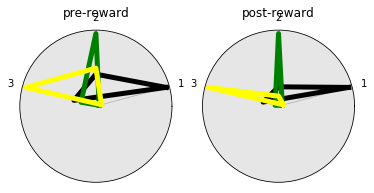

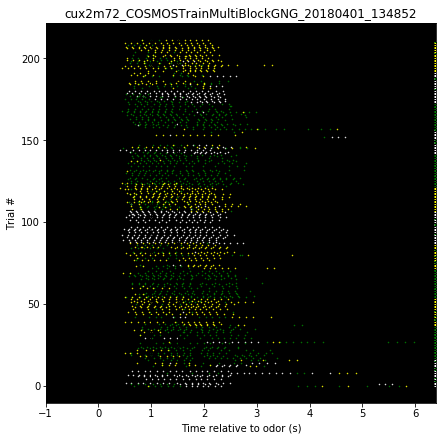

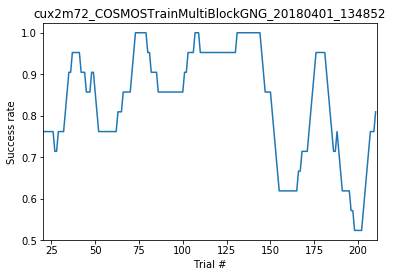

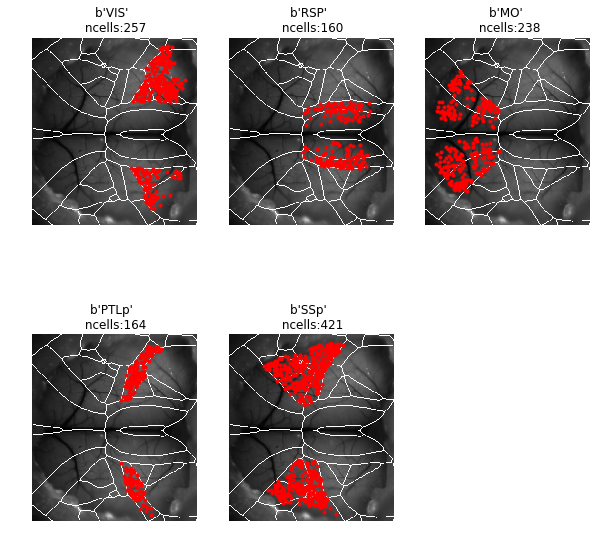

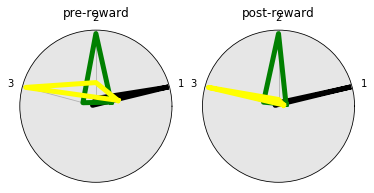

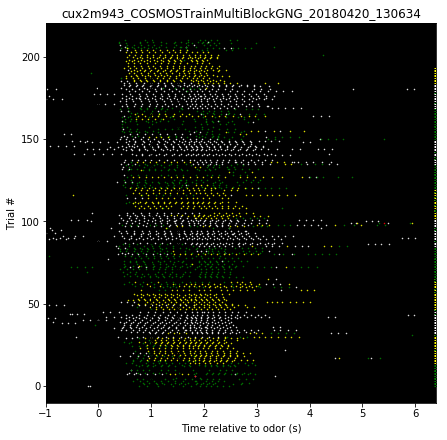

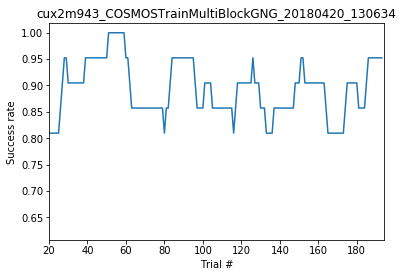

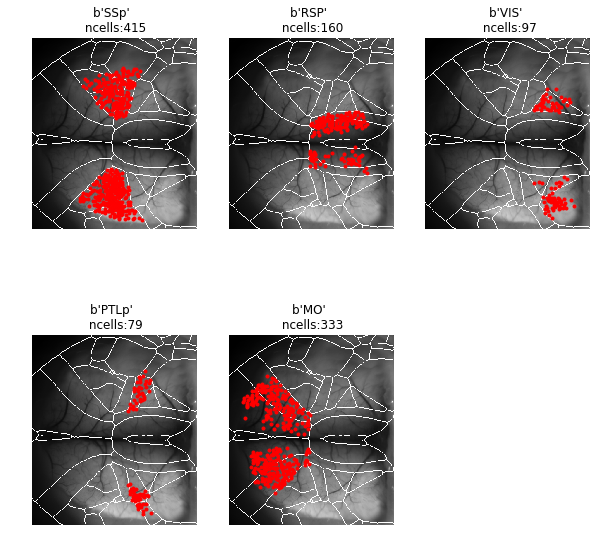

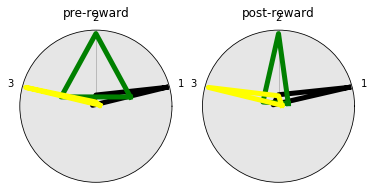

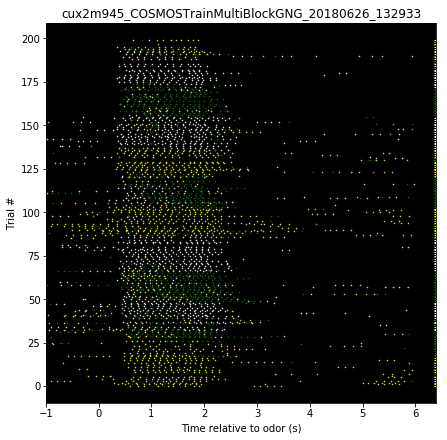

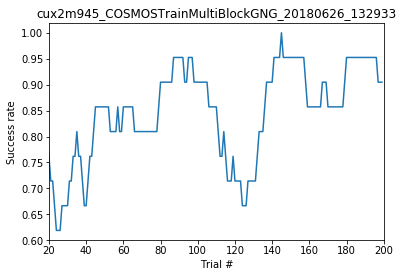

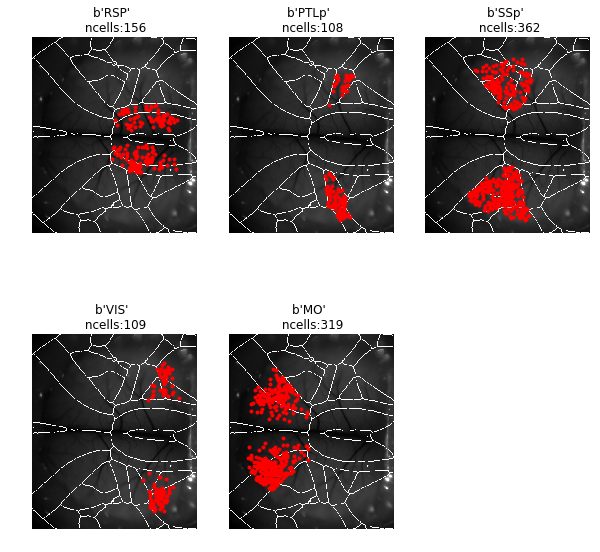

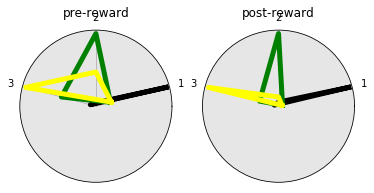

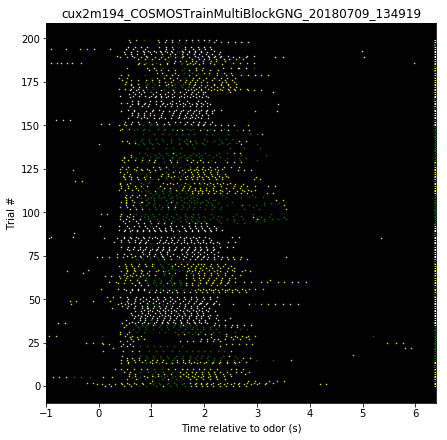

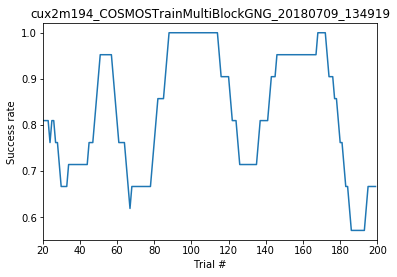

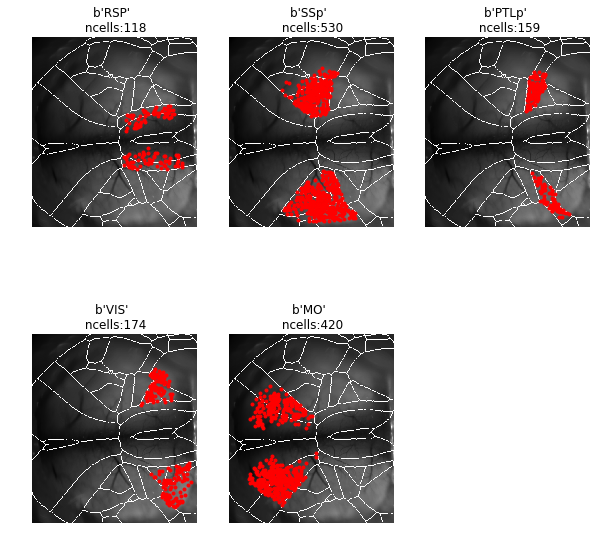

In [4]:
# Load all of the datasets (each their own class).
allCT = []
for dataset_id in datasets:
    dataset = params.DATASETS[dataset_id]
    print(dataset['date'], dataset['name'])
    dataset['data_root'] = data_dir
    dataset['fig_save_dir'] = general_plots_save_dir
    dataset['behavior_dir'] = bpod_dir
    
    startt = time.time()
    CT = CosmosTraces(dataset, do_region_plots=True)
    allCT.append(CT)
    print('Elapsed time: '+str(time.time() - startt))

In [5]:
# Extract trial types (and double check that percent correct on task is high enough).
all_pct_correct = []
all_trial_sets = []
for CT in allCT:
    BD = CT.bd
    all_pct_correct.append(np.sum(BD.success)/len(BD.success))

    min_block_trial = 4
    min_spout_selectivity = 0

    trial_sets, trial_labels = utils.get_trial_sets_COSMOSTrainMultiBlockGNG(BD, min_block_trial, 
                                                                             min_spout_selectivity)
    all_trial_sets.append(trial_sets)
print(all_pct_correct)

[0.8388625592417062, 0.8917525773195877, 0.845, 0.825]


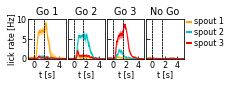

In [6]:
"""
Median lick rate to each spout for each trial type (n=4 mice, err=S.E.M. across mice, session performance > 80%). 
First three exploratory trials in each block are excluded.
"""
spout_colors = ['orange', 'c', 'r']

matplotlib.rcParams.update({'xtick.major.pad': '2'})
matplotlib.rcParams.update({'ytick.major.pad': '2'})
matplotlib.rcParams.update({'font.size': 8})
matplotlib.rcParams['pdf.fonttype'] = 42 # truetype
matplotlib.rcParams['ps.fonttype'] = 42

plt.figure()
trial_labels = ['Go 1', 'Go 2', 'Go 3', 'No Go']
fig, axes = plt.subplots(nrows=1, ncols=4)
for trial_type, trial_label in enumerate(trial_labels):
    spout_licks_means = dict()
#     plt.subplot(1, 4, trial_type+1)
    plt.sca(axes[trial_type])
    for ind, CT in enumerate(allCT):
        BD = CT.bd
        trial_set = all_trial_sets[ind]
        trials = trial_set[trial_type]

        for spout in BD.spout_lick_rates.keys():
#         for spout in [3]:
            trial_licks = BD.spout_lick_rates[spout][trials,:]
            t = np.arange(trial_licks.shape[1])*CT.dt

            licks_mean = np.mean(trial_licks, axis=0)
            licks_mean = scipy.signal.savgol_filter(licks_mean, 11, 3)
            nt = 250
            if spout in spout_licks_means.keys():
                spout_licks_means[spout] = np.vstack((spout_licks_means[spout], licks_mean[:nt]))
            else:
                spout_licks_means[spout] = licks_mean[:nt]
            
    for label, spout in enumerate([0, 2, 3]):
        mean = np.median(spout_licks_means[spout], axis=0) # across mice.
        sem = scipy.stats.sem(spout_licks_means[spout], axis=0) # across mice. 
        t = np.arange(len(mean))*CT.dt - BD.stimulus_times[0]

        plt.plot(t, mean, label='spout ' + str(label+1), color=spout_colors[label], linewidth=1)
        plt.fill_between(t, mean-sem, y2=mean+sem, color=spout_colors[label], alpha=0.5, interpolate=True, linewidth=0)
        plt.axvline(x=0, color='k', linestyle='--', linewidth=0.5)
        plt.axvline(x=1.5, color='k', linestyle='--', linewidth=0.5)
        if trial_type > 0:
            plt.gca().axes.yaxis.set_ticklabels([])
        if trial_type == 0:
            plt.ylabel('lick rate [Hz]')
            plt.gca().yaxis.labelpad = 0
        plt.gca().axes.tick_params(direction='in') # Control properties of ticks
        plt.xlabel('t [s]')
        plt.gca().xaxis.labelpad = 0.1 # Contol padding of xlabel
    plt.ylim([0, 10])
    plt.yticks([0, 5, 10])
    plt.xticks([0, 2, 4])
    plt.xlim([-1, 5])
    plt.title(trial_label)
    plt.gca().title.set_position([0.5, 0.95]) # Control title position (as fraction of subplot)
fig.subplots_adjust(wspace=.05, bottom=0.25, top=0.8, right=0.8) # Control padding around subplots
legend = plt.legend(frameon=False, bbox_to_anchor=(0.9, 0.1), handlelength=0.5, 
                    handletextpad=0.3, labelspacing=0.2)
for line in legend.get_lines():
    line.set_linewidth(2.0)
legend.get_frame().set_facecolor('none')
plt.gcf().set_size_inches(w=3.2, h=1) # Control size of figure in inches
plt.savefig(fig_save_dir + 'licks.pdf', transparent=True) # Note, to accept fonts in illustrator, do -->Resolve fonts


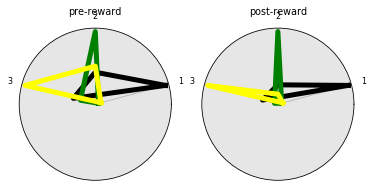

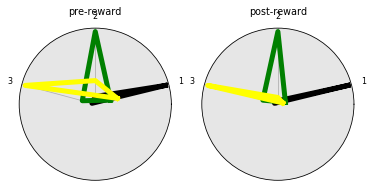

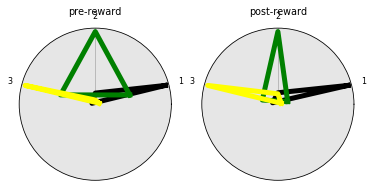

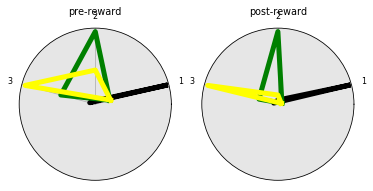

In [7]:
# Now generate rose plot averaged across mice with pre and post reward. 
all_pre_selectivity = []
all_post_selectivity = []
for CT in allCT:
    BD = CT.bd
    pre_out, post_out = BD.plot_spout_selectivity(min_trial=10, do_save=False)
    all_pre_selectivity.append(pre_out)
    all_post_selectivity.append(post_out)

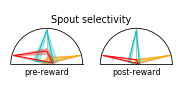

In [8]:
"""
Histogram of spout lick fraction as a function of target spout,
during the 1.5 seconds before or after reward delivery. 
Median across mice (n=4 mice, err=S.E.M. across mice).
"""
titles = ['pre-reward', 'post-reward']
fig, axarr = plt.subplots(1, 2, subplot_kw=dict(projection='polar'))

for eind, epoch in enumerate([all_pre_selectivity, all_post_selectivity]):
    for ind, selectivity in enumerate(epoch):
        spout_dist = selectivity['spout_dist']
        theta = selectivity['theta']

        if ind == 0:
            all_spout_dist = spout_dist
        else:
            all_spout_dist = np.dstack((all_spout_dist, spout_dist))

    med_spout_dist = np.median(all_spout_dist, axis=2)
    sem_spout_dist = scipy.stats.sem(all_spout_dist, axis=2)
    spout_dist = med_spout_dist
    nspouts = len(theta)
    colors = spout_colors

     # Actually make the polar plots now.
#     ax = plt.subplot(1,2,eind+1, projection='polar',
#                      facecolor=[.9, .9, .9])
    ax = axarr[eind]
    plt.sca(ax)

    ax.set_rmax(1)
    ax.set_rticks([])
    ax.set_xticks(np.mod(theta, 2 * np.pi))
    ax.set_xticklabels(np.arange(nspouts) + 1)

    for target_spout in range(spout_dist.shape[0]):
        d = spout_dist[target_spout, :]
        s = sem_spout_dist[target_spout, :]
        d = d / np.max(d)
        ax.plot(np.append(theta, theta[0]), np.append(d, d[0]),
                color=colors[target_spout].replace('white', 'black'),
                linewidth=1)

        ax.fill_between(np.append(theta, theta[0]), 
                        np.append(d, d[0]) - np.append(s, s[0]), 
                        np.append(d, d[0]) + np.append(s, s[0]),
                        color=colors[target_spout].replace('white', 'black'), 
                        alpha=0.3)

        v = matplotlib.__version__.split('.')
        if int(v[0])>1 and int(v[1])>0:
            ### If you upgrade to matplotlib v2.1 then you should be able to use:
            ax.set_thetamin(0)
            ax.set_thetamax(180)
        else:
            warning('Please upgrade matplotlib to v2.1 or greater.')
        plt.xlabel(titles[eind])
        fig.subplots_adjust(wspace=-.2, bottom=0, top=1, right=1) # Control padding around subplots
        plt.gca().axes.xaxis.set_ticklabels([])
        plt.gca().xaxis.labelpad = -15 # Contol padding of xlabel
st = plt.suptitle('Spout selectivity')
st.set_position([0.56, .94]) # Control title position (as fraction of subplot)

plt.gcf().set_size_inches(w=3.2, h=1) # Control size of figure in inches
plt.savefig(fig_save_dir + 'lick_selectivity.pdf', transparent=True) # Note, to accept fonts in illustrator, do -->Resolve fonts



In [9]:
# Plot within block improvement in accuracy, across mice? ('The lag plot')

In [10]:
CT.name

'cux2ai148m194_COSMOSTrainMultiBlockGNG_2'

In [11]:
fig_save_dir

'/home/user/Dropbox/cosmos/fig_plots/fig3/behavior_summary/'

In [12]:
%pdb

Automatic pdb calling has been turned ON


Saving to:  /home/user/Dropbox/cosmos/trace_analysis/20180401/cux2ai148m72_COSMOSTrainMultiBlockGNG_1/licks.pdf
Saving to:  /home/user/Dropbox/cosmos/trace_analysis/20180420/cux2ai148m943_COSMOSTrainMultiBlockGNG_1/licks.pdf
Saving to:  /home/user/Dropbox/cosmos/trace_analysis/20180626/cux2ai148m945_COSMOSTrainMultiBlockGNG_1/licks.pdf
Saving to:  /home/user/Dropbox/cosmos/trace_analysis/20180709/cux2ai148m194_COSMOSTrainMultiBlockGNG_2/licks.pdf


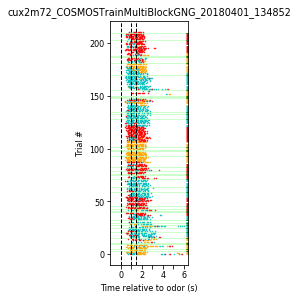

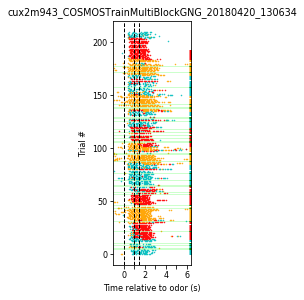

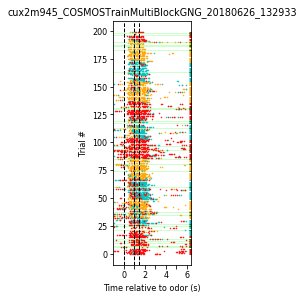

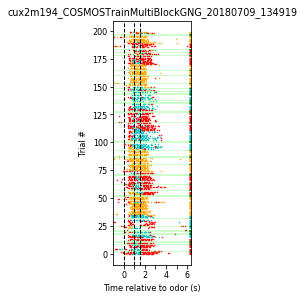

In [13]:
for CT in allCT:
    BD = CT.bd
    BD.plot_lick_times(alt_colors=True, underlay_nogo=True)

    plt.gcf().set_size_inches(w=1.4, h=4.5) # Control size of figure in inches
    plt.xticks([0, 1, 2, 3, 4, 5, 6], ['0', '', '2', '', '4', '', '6'])
    plt.savefig(fig_save_dir + 'lick_raster_'+CT.name+'.pdf', transparent=True) # Note, to accept fonts in illustrator, do -->Resolve fonts



Using TensorFlow backend.
/home/user/anaconda3/envs/cosmostools3_keras222_mplt21_2/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars


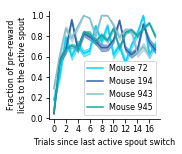

In [14]:
import keras
import seaborn as sns

bin_size = 1

plt.figure(figsize=(8,8))
# plt.rc('font', size=8)
# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams.update({'xtick.major.pad': '2'})
matplotlib.rcParams.update({'ytick.major.pad': '2'})
matplotlib.rcParams.update({'font.size': 8})
matplotlib.rcParams['pdf.fonttype'] = 42 # truetype
matplotlib.rcParams['ps.fonttype'] = 42


mouse_colors = ['#00d2ff', '#3063A5', '#86becb', '#1aa3a3'] # blues

all_lines = []
for iter, CT in enumerate([allCT[0], allCT[3], allCT[1], allCT[2]]):
    BD = CT.bd
    
    # Get true spout positions
    true_pos = BD.spout_positions.copy()
    true_pos[np.where(true_pos == 1)[0]] = 2
    true_pos_ = true_pos - 2
    true_pos = keras.utils.to_categorical(true_pos_)

    # Unthresholded number of licks pre-reward to each spout on each trial
    t_range = [BD.stimulus_times[0] + 1.0, BD.stimulus_times[0] + 1.50]
    inds = np.where((BD.lick_mat_t > t_range[0]) &
                    (BD.lick_mat_t < t_range[1]))[0]
    pre_odor_licks = [[np.sum(BD.spout_lick_mat[spout][trial, inds])
                      for trial in range(BD.ntrials)]
                      for spout in range(4)]
    pre_odor_licks = np.array(pre_odor_licks)[[0, 2, 3], :].T
    target_licks = [licks[spout]/np.sum(licks) for licks, spout in zip(pre_odor_licks, true_pos_)]
    target_licks = np.array(target_licks)

    x_range = range(0, max(BD.ind_within_block) - bin_size, bin_size)
    accuracy = []
    for block in x_range:
        # Get trials that we're processing simultaneously--those sharing a lag+bin
        block_trials = np.concatenate([np.where(BD.ind_within_block == bb)[0]
                                       for bb in np.arange(block, block+bin_size)])
        
        # Only talk about trials where the mouse licked pre-reward
        block_trials = np.intersect1d(np.where(np.sum(pre_odor_licks, 1) > 0)[0], block_trials)
        block_trials = np.sort(block_trials)
        
        # Compute the fraction of trials where the most licked spout matches the active spout
        num_target = len(np.where(np.isfinite(target_licks))[0])
        accuracy.append([np.nanmean(target_licks[block_trials]),
                         np.nanstd(target_licks[block_trials])/np.sqrt(num_target)])

    # Generate plot
    accuracy = np.array(accuracy)
    plt.plot(x_range, accuracy[:, 0], '-', color=mouse_colors[iter], 
             label='Mouse ' + CT.name.split('_')[0].split('m')[1])
    plt.fill_between(x_range, accuracy[:, 0]-accuracy[:, 1],
                     accuracy[:, 0]+accuracy[:, 1], color=mouse_colors[iter], alpha=0.5)
    all_lines.append(accuracy[:10, 0])
all_lines = np.vstack(all_lines)
plt.xlabel('Trials since last active spout switch')
plt.ylabel('Fraction of pre-reward\nlicks to the active spout')
plt.legend()
plt.xticks(x_range[::2])
# plt.rcParams.update({'axes.labelsize': 10})
sns.despine()
plt.gcf().set_size_inches(w=2, h=2) # Control size of figure in inches
plt.savefig(fig_save_dir + 'lick_lag' + str(bin_size) + '.pdf', transparent=True)

In [15]:
import statsmodels.stats.multitest as mt

# Critical value for statistical test + acceptable FWER
alpha = 0.05

# LUT for significance stars
def get_stars(p_value):
    """ Take in a p-value and return stars. """
    star_map=[('ns', np.inf), ('*', 0.05),
              ('**', 0.01), ('***', 0.001),
              ('****', 0.0001)]
    if np.isinf(p_value) or np.isnan(p_value):
        return 'ns'

    for label, thresh in star_map[::-1]:
        if p_value < thresh:
            return label


t(0) v t(1), n =  4 , p =  0.0149393134 *; paired t-test (fdr corrected)
t(1) v t(2), n =  4 , p =  0.0439500971 *; paired t-test (fdr corrected)
t(0) v t(2), n =  4 , p =  1.14871e-05 ****; paired t-test (fdr corrected)


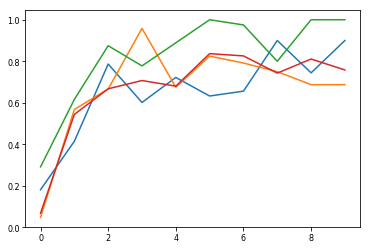

In [16]:
for line in all_lines:
    plt.plot(line)
    
pairs = [[0, 1], [1, 2], [0, 2]]
pvals = []
for pair in pairs:
    pvals.append(scipy.stats.ttest_rel(all_lines[:, pair[0]], all_lines[:, pair[1]]).pvalue)

reject, pvals, _, _ = mt.multipletests(pvals, alpha=alpha, method='fdr_bh')
for pvalue, pair in zip(pvals, pairs):
    s = get_stars(pvalue)
    print('t(' + str(pair[0]) + ') v t(' + str(pair[1]) + '), n = ', np.shape(all_lines)[0],
          ', p = ', np.round(pvalue, 10), s + '; paired t-test (fdr corrected)')

In [17]:
# Now select which dataset to plot for summary plots
d = 1
CT = allCT[d]
trial_set = all_trial_sets[d]
smoothed_spikes = gaussian_filter1d(CT.St, 2, axis=1)

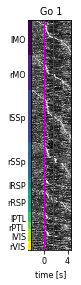

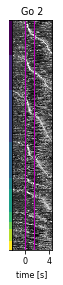

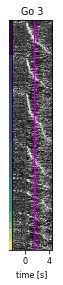

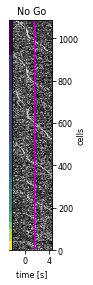

In [18]:
# Plot average trace for all cells in one mouse for each trial type. Order within each region?
# smooth_spikes = gaussian_filter1d(CT.St, 1.5, axis=1, mode='constant')

params = [{'ttype':0, 'order':'peak', 'rl':False, 'll':True},
          {'ttype':1, 'order':'peak', 'rl':False, 'll':False},
          {'ttype':2, 'order':'peak', 'rl':False, 'll':False},
          {'ttype':3, 'order':'peak', 'rl':True, 'll':False},
         ]

for p in params:
    ttype = p['ttype']
    order = p['order']
    rl = p['rl']
    ll = p['ll']
    
    if order == 'peak':
        ordering = 'peak'
    elif order == 'prev':
        ordering = ordering
    which_trials = np.where(trial_set[ttype])[0]
    event_frames = CT.fps*np.array([0, CT.bd.stimulus_times[0], 
                                    CT.bd.stimulus_times[0]+1.5])
    ordering, region_labels = utils.plot_average_by_region(traces=smoothed_spikes,
                                     cells_in_region=CT.cells_in_region,
                                     regions=CT.regions,
                                     hemisphere_of_cell=CT.hemisphere_of_cell,
                                     dt=CT.dt,
                                     which_trials=which_trials,
                                     which_regions=['MO', 'SSp', 'RSP', 'PTLp', 'VIS'],
                                     ordering=ordering,
                                     event_frames=event_frames,
                                     right_labels=rl,
                                     left_labels=ll,
                                     titlestr=trial_labels[ttype],
                                     region_cmap='viridis',
                                    )
    plt.clim([-2, 4])
    plt.gcf().subplots_adjust(wspace=-.2, bottom=0.1, top=0.95, left=0.3, right=.7) # Control padding around subplots
    plt.gcf().set_size_inches(w=1.5, h=4) # Control size of figure in inches
    plt.savefig(fig_save_dir + 'traces'+trial_labels[ttype]+'_expt'+str(datasets[d])+'.pdf', 
                transparent=True, rasterized=True, dpi=600)


False
---Plotting contours: 18.14868927001953 seconds ---


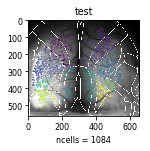

In [19]:
# Plot locations/rois of cells colored by region corresponding to 
# the plotted traces from plot_average_by_region.

avgs = np.mean(CT.St, axis=2)
title = 'test'
fig = plt.figure(figsize=(20, 10))
CP = CellPlotter(avgs, avgs, CT.footprints,
                 CT.mean_image, spikes=None,
                 date='',
                 name=title,
                 fig_save_path=None,
                 suffix=None,
                 cmap=plt.cm.winter)

CP.set_highlighted_neurons(np.arange(CT.ncells), alpha=np.ones(CT.ncells))

### This relies on information about region_labels from plot_average_by_region. Potentially could
### factor this out.
cmap = matplotlib.cm.get_cmap('viridis', len(np.unique((region_labels))))
color_list = np.squeeze(cmap(region_labels/np.max(region_labels)))

inds = np.argsort(ordering)
color_list = color_list[inds, :]

CP.plot_contours(highlight_neurons=True,
                 display_numbers=False,
                 ax=plt.subplot(111),
                 atlas_outline=CT.atlas_outline,
                 maxthr=0.95,
                 just_show_highlighted=False,
                 highlight_color=None,
                 edge_color=(0,0,0,0),
                 color_list=color_list)

plt.gcf().set_size_inches(w=2, h=2) # Control size of figure in inches
plt.savefig(fig_save_dir + 'contours'+'_expt'+str(datasets[d])+'.pdf', transparent=True, rasterized=True, dpi=600)


In [20]:
# Then compare across mice with one trial type?

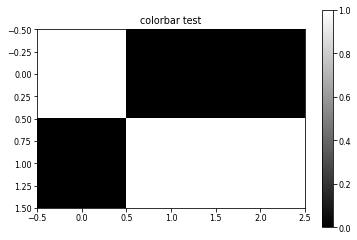

In [21]:
### Use this to saveout the colorbar.
plt.figure()
plt.imshow(np.array([[1, 0, 0], [0, 1, 1]]), cmap='gray')
plt.colorbar()
plt.title('colorbar test')
plt.savefig(fig_save_dir + 'colorbar.pdf', transparent=True, rasterized=True, dpi=600)

In [22]:
%pdb

Automatic pdb calling has been turned OFF


/home/user/Dropbox/cosmos/fig_plots/fig3/behavior_summary/cells/
/home/user/Dropbox/cosmos/fig_plots/fig3/behavior_summary/cells/
/home/user/Dropbox/cosmos/fig_plots/fig3/behavior_summary/cells/
/home/user/Dropbox/cosmos/fig_plots/fig3/behavior_summary/cells/
/home/user/Dropbox/cosmos/fig_plots/fig3/behavior_summary/cells/
/home/user/Dropbox/cosmos/fig_plots/fig3/behavior_summary/cells/
/home/user/Dropbox/cosmos/fig_plots/fig3/behavior_summary/cells/
/home/user/Dropbox/cosmos/fig_plots/fig3/behavior_summary/cells/
/home/user/Dropbox/cosmos/fig_plots/fig3/behavior_summary/cells/
/home/user/Dropbox/cosmos/fig_plots/fig3/behavior_summary/cells/
/home/user/Dropbox/cosmos/fig_plots/fig3/behavior_summary/cells/
/home/user/Dropbox/cosmos/fig_plots/fig3/behavior_summary/cells/
/home/user/Dropbox/cosmos/fig_plots/fig3/behavior_summary/cells/


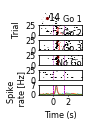

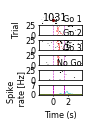

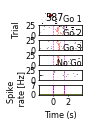

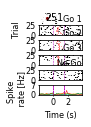

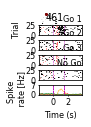

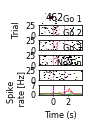

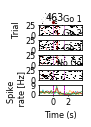

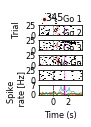

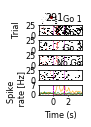

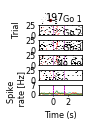

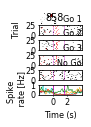

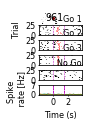

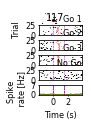

In [23]:
### Plot individual cells across trials.
cell_infos = [
            {'dataset': 7, 'id': 14},
            {'dataset': 7, 'id': 1031},
            {'dataset': 7, 'id': 587},
            {'dataset': 7, 'id': 251},
            {'dataset': 19, 'id': 461},
            {'dataset': 19, 'id': 462},
            {'dataset': 19, 'id': 463, 'ylim': [0, 9]},
            {'dataset': 19, 'id': 345},
            {'dataset': 19, 'id': 291},
            {'dataset': 19, 'id': 197},
            {'dataset': 19, 'id': 858, 'ylim':[0,1]}, #lickoff
            {'dataset': 7, 'id': 961}, #lickoff
            {'dataset': 7, 'id': 117}, #lickoff
             ]

cells_dir = os.path.join(fig_save_dir, 'cells/')
if not os.path.isdir(cells_dir):
    os.makedirs(cells_dir)

for cell_info in cell_infos:
    d = np.where(np.array(datasets) == cell_info['dataset'])[0][0]
    CT = allCT[d]
    lick_onsets = utils.get_lick_onsets(CT.bd.spout_lick_rates)
    smoothed_spikes = gaussian_filter1d(CT.St, 1.5, axis=1, mode='constant')
    cell_id = cell_info['id']
    trial_sets = all_trial_sets[d]
    names = trial_labels
    trial_colors = ['orange', 'c', 'r', 'g']
    event_frames = CT.fps*np.array([CT.bd.stimulus_times[0], 
                                    CT.bd.stimulus_times[0]+1.5])    
    
    if 'ylim' in cell_info.keys():
        ylims_avg = cell_info['ylim']
    else:
        ylims_avg = [0, 7]
    utils.plot_formatted_cell_across_trials(cell_id, smoothed_spikes, CT.Tt, trial_sets, names, trial_colors, 
                                      event_frames, CT.centroids, CT.atlas_tform,
                                      clim=[0, 4], lick_onsets=lick_onsets,
                                      xlims=[-2, 4],
                                      ylims_trials=[0, 25],
                                      ylims_avg=ylims_avg)
    
#     plt.gcf().set_size_inches(w=1.55, h=3) # Control size of figure in inches
    plt.gcf().set_size_inches(w=0.75, h=1.3) # Control size of figure in inches
    print(cells_dir)
    plt.savefig(cells_dir + 'trials_{}_id{}'.format(cell_info['dataset'], cell_info['id'])+'.pdf', transparent=True, rasterized=True, dpi=600)


In [24]:
### Good cells
# dataset 7: [5, 14, 24, 29, 36, 87]
# dataset 19: [32, 36, 95, 107, 109, 129, 147, 159, 170, 185, 193, 197, 259, 269, 274, 291, 302, 312, 345, 380, 397, 399, 425, 445, 448, 452, 461, 462, 463]

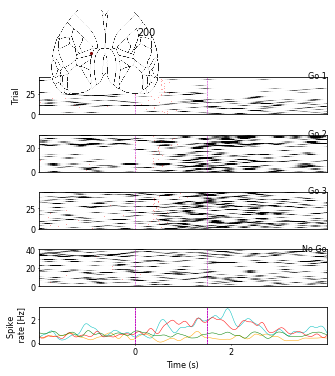

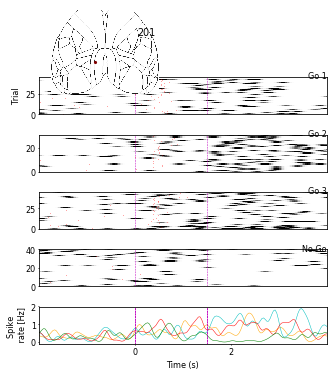

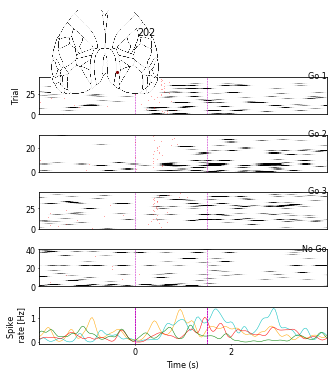

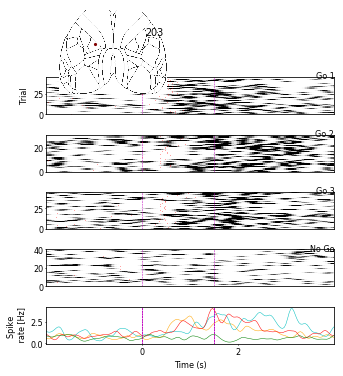

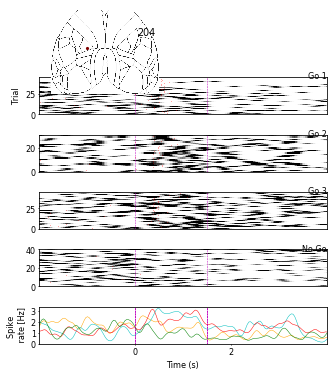

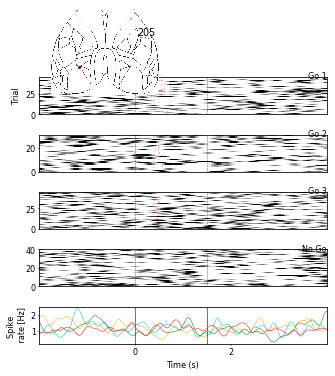

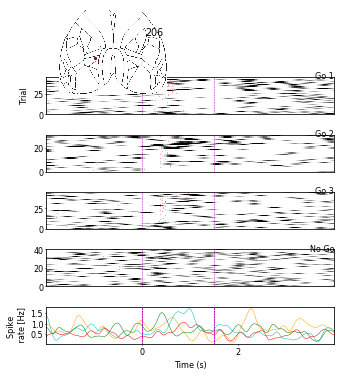

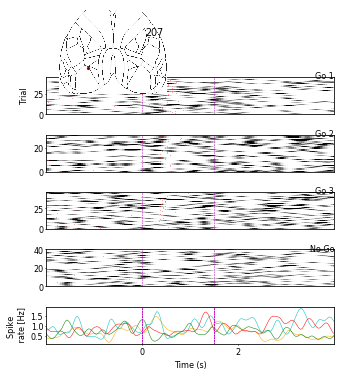

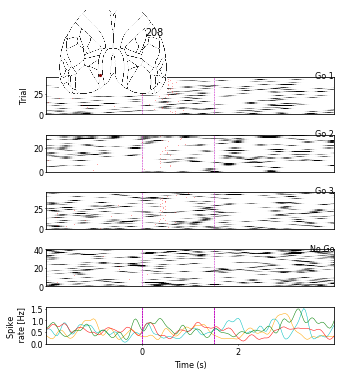

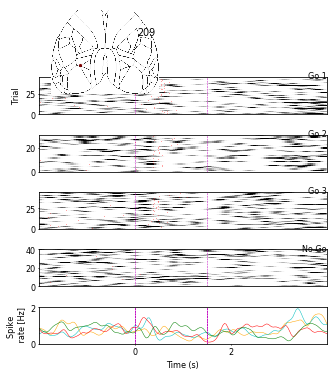

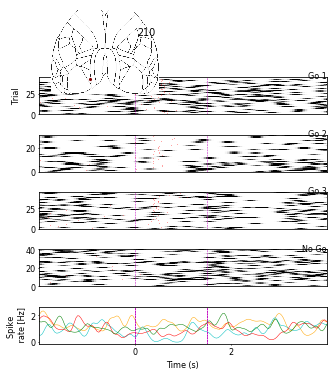

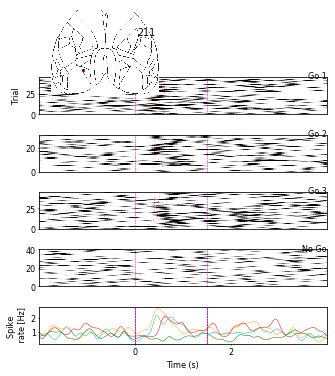

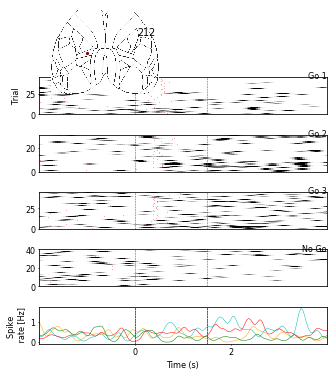

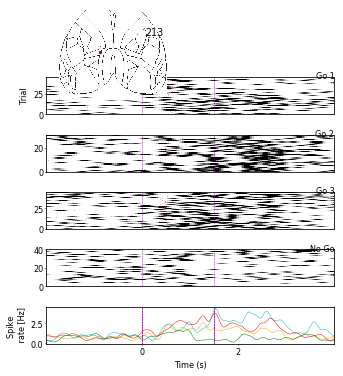

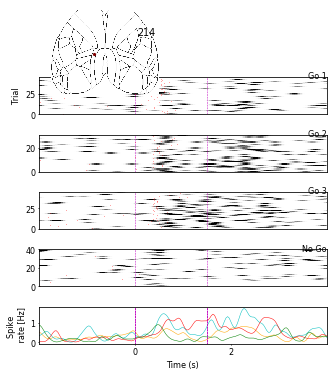

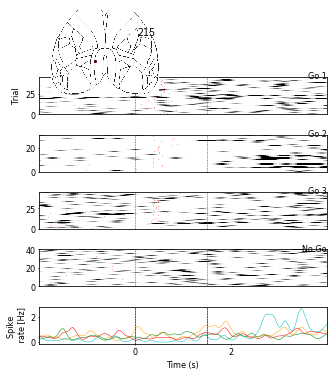

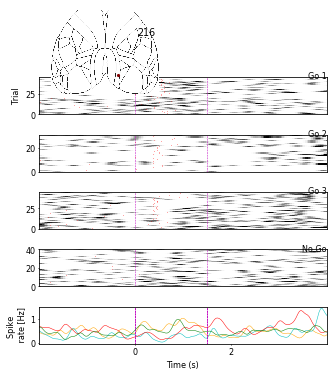

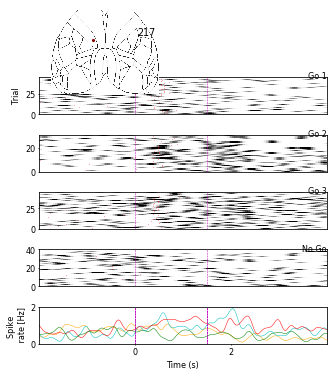

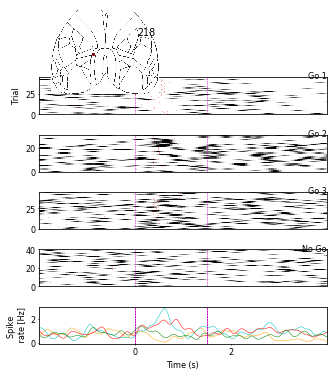

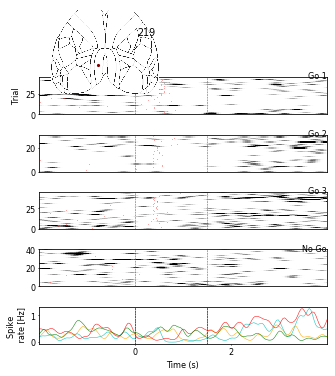

In [25]:
# Plot a lot of cells to choose from
do_plot_indiv_cells = 1

if do_plot_indiv_cells:
    d = np.where(np.array(datasets) == 19)[0][0]
    CT = allCT[d]
    for cell_id in range(200, 220):
        lick_onsets = utils.get_lick_onsets(CT.bd.spout_lick_rates)
        smoothed_spikes = gaussian_filter1d(CT.St, 2, axis=1)
        trial_sets = all_trial_sets[d]
        names = trial_labels
        trial_colors = ['orange', 'c', 'r', 'g']
        event_frames = CT.fps*np.array([CT.bd.stimulus_times[0], 
                                        CT.bd.stimulus_times[0]+1.5])    

        utils.plot_formatted_cell_across_trials(cell_id, smoothed_spikes, CT.Tt, trial_sets, names, trial_colors, 
                                          event_frames, CT.centroids, CT.atlas_tform,
                                          clim=[0, 5], lick_onsets=lick_onsets,
                                          xlims=[-2, 4])

/home/user/anaconda3/envs/cosmostools3_keras222_mplt21_2/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


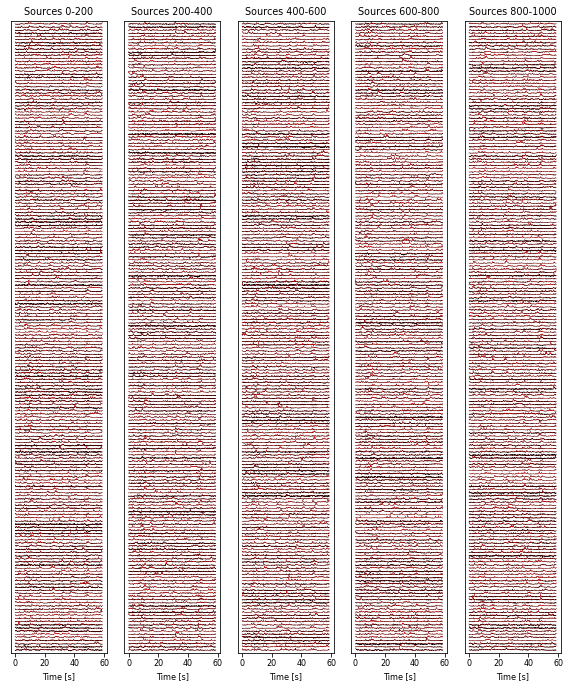

In [28]:
### Plot ALL traces, with the smoothed overlaid on raw. This can be a supplemental figure on its own. 

ct_ind = 1
traces = allCT[ct_ind].C
traces_raw = allCT[ct_ind].F
do_zscore = True
nt = 2000
dt = 1/34.0

neuron_ind = np.arange(1000)
# plt.figure(figsize=(10, 300))
plt.figure(figsize=(50, 60))

subplot_ind = 0
np.random.seed(1)
for iter, idx in enumerate(np.random.permutation(neuron_ind)):
    if np.mod(iter, 200) == 0:
        subplot_ind += 1
    plt.subplot(1, 5, subplot_ind)
    t = dt * np.arange(nt)
    zscale = 8
    scale_factor = np.std(traces_raw[idx, :nt])*zscale
    normed_trace = traces[idx, :nt]/scale_factor
    normed_raw_trace = traces_raw[idx, :nt]/scale_factor
    
    plt.plot(t, normed_raw_trace + iter, color='k', linewidth=0.25)
    plt.plot(t, normed_trace + iter, color='r', linewidth=0.25)
    plt.ylim([(subplot_ind-1)*200-1, subplot_ind*200])
    plt.yticks([])
#     plt.xlim([0, 60]*dt * np.arange(nt))
    plt.xlabel('Time [s]')
    
    plt.title('Sources {}-{}'.format((subplot_ind-1)*200, subplot_ind*200))

plt.gcf().set_size_inches(w=8, h=9.6) # Control size of figure in inches
plt.savefig(fig_save_dir + '1000_sources_dataset_{}'.format(datasets[ct_ind])+'.pdf', transparent=True, rasterized=True, dpi=800)
plt.tight_layout()